### Build a Basic Chatbot with LangGraph (Graph API)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END # for buildig a StateGraph
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    """
    Its type is a simple dictionary
    """
    messages : Annotated[list, add_messages]

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# First way to use a LLM Model
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A554185ED0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A5542DDED0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
# Second and more commom way to use any Model
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A5542FAB50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A5542FB790>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Creating a New Node in StateGraph
# In every Node we have to create the definition of the Node --> Node Functionality

def chatbot(state: State):
    return {"messages" : llm.invoke(state["messages"])}

In [8]:
# Starting to Build our Graph

graph_builder = StateGraph(State)

# Adding a node
graph_builder.add_node("llmchatbot", chatbot)

# Adding an edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# Compilation of Graph
graph = graph_builder.compile()

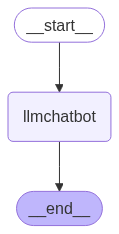

In [9]:
## Visualizing the StateGraph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as err:
    print(err)


In [10]:
response = graph.invoke({"messages":"Hi"})

In [11]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
for event in graph.stream({"messages" : "Hi How are you?"}):
    print(event)

{'llmchatbot': {'messages': AIMessage(content="I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm here and ready to help with any questions or topics you'd like to discuss. How about you? How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 40, 'total_tokens': 101, 'completion_time': 0.061712849, 'prompt_time': 0.011598084, 'queue_time': 0.488249827, 'total_time': 0.073310933}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--791d68a1-d0ab-40e4-b30e-2f2f3f305c4a-0', usage_metadata={'input_tokens': 40, 'output_tokens': 61, 'total_tokens': 101})}}


In [13]:
for event in graph.stream({"messages" : "Hello, Are you a boy?"}):
    for value in event.values():
        print(value["messages"].content)

I'm not a boy or a girl. I'm a computer program designed to assist and communicate with humans. I'm a language model, which means I don't have a physical body or a personal identity in the classical sense. I exist solely to provide information, answer questions, and help with tasks to the best of my abilities. So, I'm more like a tool or a machine, rather than a boy or a girl.


## Chatbot With Tools

In [14]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph?")

{'query': 'What is Langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [15]:
## Custom function

def multiply(a: int, b: int)-> int:
    """Multiply a and b

    Args:
        a (int) : First Integer
        b (int) : Second Integer

    Returns:
        int : product of a and b
    """
    print("Using multiply func")
    return a*b

In [16]:
tools = [tool, multiply]

In [17]:
llm_with_tool = llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A5542FAB50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A5542FB790>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

In [40]:
## Creating StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node Definition
def tool_calling_llm(state: State):
    return {"messages" : llm_with_tool.invoke(state["messages"])}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Adding the Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools.
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END.
    tools_condition
)
builder.add_edge("tools", END)

# Compile the Graph
graph = builder.compile()

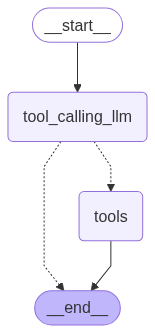

In [41]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
response = graph.invoke({"messages" : "What is the Recent TCS News?"})

In [43]:
response

{'messages': [HumanMessage(content='What is the Recent TCS News?', additional_kwargs={}, response_metadata={}, id='9cb5d1ef-4b1a-4606-b05b-b1faeda61996'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1hv5gzw4w', 'function': {'arguments': '{"end_date":null,"exclude_domains":null,"include_domains":null,"include_favicon":null,"include_images":null,"query":"Recent TCS News","search_depth":"advanced","start_date":null,"time_range":null,"topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 1857, 'total_tokens': 1931, 'completion_time': 0.099765274, 'prompt_time': 0.073507376, 'queue_time': 3.025685148, 'total_time': 0.17327265, 'prompt_tokens_details': {'cached_tokens': 1536}}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--08ce7c2a-bd17-4ed3-8d11-c5b58d6152db-0', to

In [44]:
response["messages"][-1].content

'{"query": "Recent TCS News", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newindianexpress.com/business/2025/Aug/07/amid-layoffs-tcs-to-hike-salaries-for-80-of-workforce-from-september", "title": "Amid layoffs, TCS to hike salaries for 80% of workforce from September - The New Indian Express", "score": 0.78014404, "published_date": "Thu, 07 Aug 2025 06:29:05 GMT", "content": "Published Time: 2025-08-07T06:29:05Z\\n\\nAmid layoffs, TCS to hike salaries for 80% of workforce from September\\n\\n===============\\n\\n\\n   Copied \\n\\nFollow Us\\n\\n, India’s largest IT services company, has announced that it will roll out salary hikes to nearly 80% of its employees starting September 1, 2025. The hike will apply to employees up to the C3A grade, covering freshers and mid-level professionals with up to a decade of experience. [...] Arshad Khan\\n\\n29 Jul 2025\\n\\nImage 6: TCS is actively working to move benched employees into billable roles

In [45]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the Recent TCS News?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1hv5gzw4w)
 Call ID: 1hv5gzw4w
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: None
    include_images: None
    query: Recent TCS News
    search_depth: advanced
    start_date: None
    time_range: None
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent TCS News", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newindianexpress.com/business/2025/Aug/07/amid-layoffs-tcs-to-hike-salaries-for-80-of-workforce-from-september", "title": "Amid layoffs, TCS to hike salaries for 80% of workforce from September - The New Indian Express", "score": 0.78014404, "published_date": "Thu, 07 Aug 2025 06:29

In [46]:
response = graph.invoke({"messages" : "What is 7 multiply 5?"})

Using multiply func


In [47]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 7 multiply 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (hxfhfhtcx)
 Call ID: hxfhfhtcx
  Args:
    a: 7
    b: 5
================================= Tool Message =================================
Name: multiply

35


### ReAct Agent Architecture

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_tavily import TavilySearch

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Creating the Nodes

llm = init_chat_model("groq:llama-3.1-8b-instant")

# tools
tool = TavilySearch(max_results=2)

def multiply(a: int, b: int)-> int:
    """Multiply a and b

    Args:
        a (int) : First Integer
        b (int) : Second Integer

    Returns:
        int : product of a and b
    """
    print("Using multiply func")
    return a*b

tools = [tool, multiply]

# Binding llm with tools
ReAct_agent_llm = llm.bind_tools(tools)

def ReActAgent(state: State):
    return {"messages" : ReAct_agent_llm.invoke(state["messages"])}


In [5]:
## Creating the StateGraph Using Above Nodes

graph_builder = StateGraph(State)

# Adding Nodes
graph_builder.add_node("ReActAgent", ReActAgent)
graph_builder.add_node("tools", ToolNode(tools))

# Adding Edges
graph_builder.add_edge(START, "ReActAgent")
graph_builder.add_conditional_edges(
    "ReActAgent",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools.
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END.
    tools_condition
)
graph_builder.add_edge("tools", "ReActAgent")

graph = graph_builder.compile()

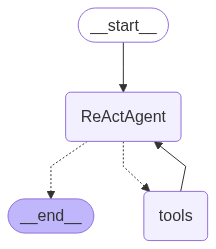

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

Using multiply func
================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (s60qpvw1s)
 Call ID: s60qpvw1s
  Args:
    query: AI news
    time_range: day
    topic: news
  multiply (h7hr2383d)
 Call ID: h7hr2383d
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/meta-acquires-waveforms-tesla-shuts-dojo-team-apple-loses-ai-staff-2508/", "title": "Meta Acquires WaveForms, Tesla Shuts Down Dojo Team, and Apple Loses AI Staff - AInvest", "score": 0.6175132, "published_date": "Fri, 08 Aug 2025 23:13:22 GMT", "content": "Meta Acquires WaveForms, Tesla Shuts Down Dojo Team, and Apple Loses AI Staff Ima

In [10]:
response

{'messages': [HumanMessage(content='Give me the recent ai news and then multiply 5 by 10', additional_kwargs={}, response_metadata={}, id='ee8c64f5-b41b-4f5e-822d-cacad804149c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's60qpvw1s', 'function': {'arguments': '{"query":"AI news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'h7hr2383d', 'function': {'arguments': '{"a":5,"b":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 1863, 'total_tokens': 1911, 'completion_time': 0.06407336, 'prompt_time': 0.067884194, 'queue_time': 0.047300391, 'total_time': 0.131957554, 'prompt_tokens_details': {'cached_tokens': 1536}}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--47d7805a-33c9-409e-9d4e-e7ef06466498-0', tool_calls=[{'name': 'tavily_s

In [8]:
response = graph.invoke({"messages" : "Give me the Recent TCS News?"})
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The recent TCS news includes:

* Virgin Atlantic and TCS extend two-decade partnership to modernize airline operations with AI-led solutions.
* TCS to steer cloud migration program for Finnish telecom leader DNA in a five-year partnership.
* TCS recognized as one of the world’s top 50 brands by Kantar BrandZ; brand value soars 28% YoY to $57.3Bn.
* TCS strengthens focus in the Middle East region with new facility in Oman.
* TCS ranked Denmark’s #1 IT service provider for customer satisfaction in 2025.
* TCS partners with Google Cloud to accelerate AI-led transformation in the retail sector.

These news articles are from various sources, including TCS’s official website, Marketscreener, and other reputable news outlets.


In [ ]:
response = graph.invoke({"messages": "Multiply 5 by 5"})
response["messages"][-1].pretty_print()

Using multiply func


In [28]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The multiply function returns the result of the multiplication, which is 25.


### Adding Memory in Agentic Graph

In [11]:
response = graph.invoke({"messages":"Hi My name is Ankur?"})
for convo in response["messages"]:
    convo.pretty_print()

================================ Human Message =================================

Hi My name is Ankur?
================================== Ai Message ==================================

Hello Ankur! How can I assist you today?


In [20]:
response = graph.invoke({"messages" : "What is my Name?"})
for convo in response["messages"]:
    convo.pretty_print()

================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

I don't have any information about your name. If you'd like to provide it, I can try to help you with something else.


In [23]:
# Creating the Nodes

llm = init_chat_model("groq:llama-3.1-8b-instant")

# tools
tool = TavilySearch(max_results=2)

def multiply(a: int, b: int)-> int:
    """Multiply a and b

    Args:
        a (int) : First Integer
        b (int) : Second Integer

    Returns:
        int : product of a and b
    """
    print("Using multiply func")
    return a*b

tools = [tool, multiply]

# Binding llm with tools
llm_with_tools = llm.bind_tools(tools)

def tool_calling_llm(state: State):
    return {"messages" : llm_with_tools.invoke(state["messages"])}


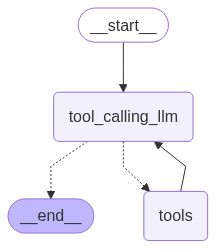

In [35]:
### Creating the StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(State)

# Creating Nodes
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Adding Edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
graph_builder.add_edge("tools", "tool_calling_llm")

## Compile the Graph
graph = graph_builder.compile(checkpointer= memory)

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# Creating a Unique Thread
config = {"configurable" : {"thread_id" : "1"}}

## Again asking the Memory based Questions?
response = graph.invoke({"messages" : "My name is Ankur. How are you?"}, config=config)
for convo in response["messages"]:
    convo.pretty_print()

================================ Human Message =================================

My name is Ankur. How are you?
================================== Ai Message ==================================

I'm functioning properly, thank you for asking.


In [37]:
response = graph.invoke({"messages" : "What is my Name?"}, config=config)
for convo in response["messages"]:
    convo.pretty_print()

================================ Human Message =================================

My name is Ankur. How are you?
================================== Ai Message ==================================

I'm functioning properly, thank you for asking.
================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (21zt7vt3x)
 Call ID: 21zt7vt3x
  Args:
    query: your name Ankur
================================= Tool Message =================================
Name: tavily_search

{"query": "your name Ankur", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Ankur_(given_name)", "title": "Ankur (given name) - Wikipedia", "content": "Ankur is an Indian masculine given name: Contents. 1 Athletes; 2 Entrepreneurs; 3 Actors; 4 Other; 5 See also. Athletes. edit · Ankur Diwakar (born 1991),", "score":

In [39]:
response = graph.invoke({"messages" : "Hey, Do you remeber my Name?"}, config= config)

print(response["messages"][-1].content)

Your name is Ankur.


### Streaming

In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [52]:
def superbot(state: State):
    return {"messages" : llm.invoke(state["messages"])}

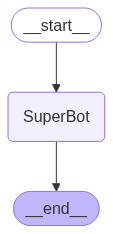

In [53]:
## Creating the StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("SuperBot", superbot)

graph_builder.add_edge(START, "SuperBot")
graph_builder.add_edge("SuperBot", END)

graph = graph_builder.compile(checkpointer = memory)
graph

In [54]:
## Invocation/ Creating thread

config = {"configurable" : {"thread_id" : "1"}}

response = graph.invoke({"messages" : "My Name is Ankur and I like Vollyball."}, config = config)
for convo in response["messages"]:
    convo.pretty_print()

================================ Human Message =================================

My Name is Ankur and I like Vollyball.
================================== Ai Message ==================================

Hello Ankur, nice to meet you. It's great to hear that you like volleyball. Volleyball is a fantastic sport that requires skill, strategy, and teamwork. Are you a player, coach, or just an enthusiastic fan of the sport?

Do you have a favorite team or player in volleyball?


### Streaming Methods

Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.
updates : This streams updates to the state of the graph after each node is called.

In [60]:
config = {"configurable" : {"thread_id" : "2"}}

for convo in graph.stream({"messages" : "My Name is Ankur and I like Vollyball."}, config = config, stream_mode="updates"):
    print(convo)

{'SuperBot': {'messages': AIMessage(content="Hi Ankur, you've mentioned your interest in volleyball a few times now. Do you have a favorite volleyball player, past or present, who inspires you with their skills or dedication to the sport?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 286, 'total_tokens': 327, 'completion_time': 0.09733511, 'prompt_time': 0.097030014, 'queue_time': 0.043993846, 'total_time': 0.194365124}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--64058ebc-2e7c-471e-817c-153009c7dd3a-0', usage_metadata={'input_tokens': 286, 'output_tokens': 41, 'total_tokens': 327})}}


In [61]:
for convo in graph.stream({"messages" : "My Name is Ankur and I like Vollyball."}, config = config, stream_mode="values"):
    print(convo)

{'messages': [HumanMessage(content='My Name is Ankur and I like Vollyball.', additional_kwargs={}, response_metadata={}, id='493ca932-2964-4303-b985-21bf674e4aa5'), AIMessage(content='Nice to meet you, Ankur. Volleyball is a great sport, both physically demanding and strategic. Do you play volleyball competitively or recreationally? What position do you usually play?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 47, 'total_tokens': 86, 'completion_time': 0.066931341, 'prompt_time': 0.007296073, 'queue_time': 0.045280987, 'total_time': 0.074227414}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--bfedf06f-8f78-47f9-8ce3-79662d3eb36e-0', usage_metadata={'input_tokens': 47, 'output_tokens': 39, 'total_tokens': 86}), HumanMessage(content='My Name is Ankur and I like Vollyball.', additional_kwargs={}, response_metadata={}, id='

In [62]:
config = {"configurable" : {"thread_id" : "3"}}

for convo in graph.stream({"messages" : "My Name is Ankur and I like Vollyball."}, config = config, stream_mode="updates"):
    print(convo)

{'SuperBot': {'messages': AIMessage(content="Hello Ankur, it's great to meet you. Volleyball is a fantastic sport, both physically and mentally demanding. Are you a professional volleyball player, a recreational player, or do you just enjoy watching it?\n\nWhich position do you like to play in volleyball? Are you more of an attacker, a setter, or a blocker?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 47, 'total_tokens': 115, 'completion_time': 0.117171347, 'prompt_time': 0.007304754, 'queue_time': 0.043703106, 'total_time': 0.124476101}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2b1ffc49-97df-4570-9377-2ac6e8a247b6-0', usage_metadata={'input_tokens': 47, 'output_tokens': 68, 'total_tokens': 115})}}


In [63]:
for convo in graph.stream({"messages" : "I also like Football."}, config = config, stream_mode="values"):
    print(convo)

{'messages': [HumanMessage(content='My Name is Ankur and I like Vollyball.', additional_kwargs={}, response_metadata={}, id='dbe77518-614b-494f-8258-8bbb571cc9b7'), AIMessage(content="Hello Ankur, it's great to meet you. Volleyball is a fantastic sport, both physically and mentally demanding. Are you a professional volleyball player, a recreational player, or do you just enjoy watching it?\n\nWhich position do you like to play in volleyball? Are you more of an attacker, a setter, or a blocker?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 47, 'total_tokens': 115, 'completion_time': 0.117171347, 'prompt_time': 0.007304754, 'queue_time': 0.043703106, 'total_time': 0.124476101}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2b1ffc49-97df-4570-9377-2ac6e8a247b6-0', usage_metadata={'input_tokens': 47, 'output_tokens': 68, 'to

In [65]:
config = {"configurable" : {"thread_id" : "4"}}

async for convo in graph.astream_events({"messages" : "My Name is Ankur and I like Vollyball."}, config = config):
    print(convo)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'My Name is Ankur and I like Vollyball.'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'a426b3de-4157-41f1-b587-4f3e7cc3b2e1', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='My Name is Ankur and I like Vollyball.', additional_kwargs={}, response_metadata={}, id='d8b5a6a1-8889-42af-b2d6-567e8e3feebd')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '5ec8f0a3-5460-4a7b-90dd-f64cb17a4026', 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:8324b4fa-a27b-7b32-0008-e1f3bcb05a2c'}, 'parent_ids': ['a426b3de-4157-41f1-b587-4f3e7cc3b2e1']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='My Name is Ankur and I like Vollyball.', additional_kwa